In [14]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import torchsummary

from torch.utils.data import DataLoader
from torch.amp import autocast, GradScaler

In [15]:
class DeepNN(nn.Module):
    def __init__(self):
        super(DeepNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(in_features=64*7*7, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [16]:
def visualize_model():
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = DeepNN().to(device)
  torchsummary.summary(model, (1, 28, 28))

In [17]:
visualize_model()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          18,496
              ReLU-5           [-1, 64, 14, 14]               0
         MaxPool2d-6             [-1, 64, 7, 7]               0
            Linear-7                  [-1, 128]         401,536
              ReLU-8                  [-1, 128]               0
            Linear-9                   [-1, 10]           1,290
Total params: 421,642
Trainable params: 421,642
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.65
Params size (MB): 1.61
Estimated Total Size (MB): 2.26
-------------------------------------------

In [18]:
def get_data_loader(batch_size=32, train=True):
  transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize((0.5,), (0.5,))
  ])
  dataset = datasets.MNIST(root='/tmp/data', train=train, download=True, transform=transform)
  data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
  return data_loader

In [19]:
def train_model(epochs=5):
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = DeepNN().to(device)
  train_loader = get_data_loader()
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  scaler = GradScaler()

  for e in range(epochs):
    model.train()
    for images, labels in train_loader:
      images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
      optimizer.zero_grad()
      with autocast(device_type='cuda'):
        outputs = model(images)
        loss = criterion(outputs, labels)
      scaler.scale(loss).backward()
      scaler.step(optimizer)
      scaler.update()
    print(f'Epoch: {e+1}, Loss: {loss.item()}')
  torch.save(model.state_dict(), '/tmp/model.pth')
  print('Model saved')

In [20]:
train_model(10)

/Users/alexvo/anaconda3/lib/python3.11/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/Users/alexvo/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch: 1, Loss: 0.14123892784118652
Epoch: 2, Loss: 0.0035196207463741302
Epoch: 3, Loss: 0.03403265029191971
Epoch: 4, Loss: 0.0032755981665104628
Epoch: 5, Loss: 0.0007500641513615847
Epoch: 6, Loss: 0.0010460790945217013
Epoch: 7, Loss: 0.00201306096278131
Epoch: 8, Loss: 4.827806151297409e-06
Epoch: 9, Loss: 8.964771404862404e-05
Epoch: 10, Loss: 0.000175406108610332
Model saved


In [21]:
def test_model():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = DeepNN().to(device)
    model.load_state_dict(torch.load('/tmp/model.pth', map_location=device))  # <-- fix path
    model.eval()

    test_loader = get_data_loader(train=False)
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy: {100 * correct / total:.2f}%')

In [22]:
test_model()

Accuracy: 98.98%


In [23]:
def visualize_predictions():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = DeepNN().to(device)
    model.load_state_dict(torch.load('/tmp/model.pth', map_location=device))  # adjust path if needed
    model.eval()

    test_loader = get_data_loader(train=False)

    images, labels = next(iter(test_loader))
    images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)

    images = images.cpu().numpy()

    fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(12, 6))
    axes = axes.flatten()

    for i in range(32):  # 4x8=32 images
        img = images[i][0]  # get the first (and only) channel for grayscale
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'Pred: {predicted[i].item()}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

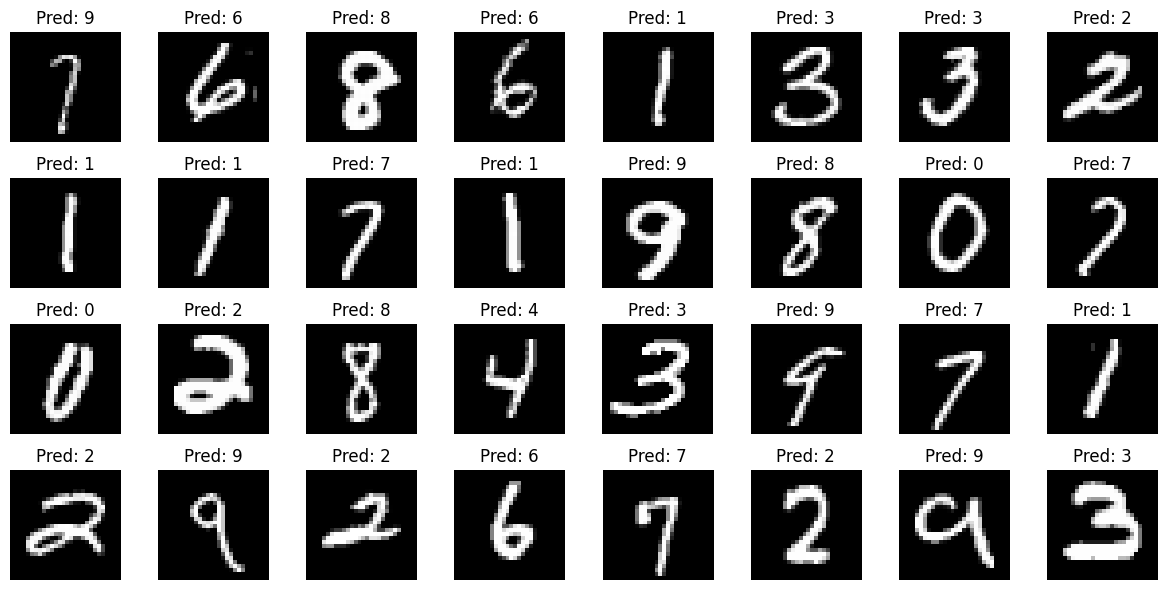

In [24]:
visualize_predictions()